## 0- Importación de Librerias 

In [254]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [255]:
#Establezco la dirección del archivo
file_location='Data\datos_TP3'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)

### Limpieza Roberto

In [256]:
# Paso el campo Time con formato 00:00 a segundos
datos_crudos['Time'] = datos_crudos.Time.str.split(pat=':', expand=True)[0].astype(int)*60+\
                                datos_crudos.Time.str.split(pat=':', expand=True)[1].astype(int)

In [257]:
datos_crudos['TE'] = datos_crudos.TE.str.split(pat='/', expand=True)[0].astype(float)

In [258]:
datos_crudos['FA'] = datos_crudos.FA.str.split(pat='/', expand=True)[0].astype(int)

In [259]:
datos_crudos['FOV_1'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[0].astype(float)
datos_crudos['FOV_2'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[1].astype(float)

In [260]:
datos_crudos['FOV_2'] = datos_crudos.apply(lambda x: x['FOV_2'] if x['FOV_2'] > 0 else x['FOV_1'], axis=1)

In [261]:
datos_crudos['MTX_1'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[0].astype(int)
datos_crudos['MTX_2'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[1].astype(float)

In [262]:
datos_crudos['MTX_2'] = datos_crudos.apply(lambda x: x['MTX_2'] if x['MTX_2'] > 0 else x['MTX_1'], axis=1)
datos_crudos['MTX_2'] = datos_crudos['MTX_2'].astype(int)

### Termina limpieza Roberto

In [264]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

In [265]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

In [266]:
datos.Anatomy.value_counts(normalize=True)*100

Head         25.284632
TL-Spine     19.461063
Extremity    18.760876
Abdomen      10.523525
Shoulder      7.211515
Pelvis        6.895809
C-Spine       6.854378
Ankle         2.365721
Hand          1.392088
Chest         1.210620
???           0.039774
Name: Anatomy, dtype: float64

In [267]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

In [268]:
#Matriz de Features
# Esto hay que modificar con la limpieza
X = datos[['PatientOrient','Plane','Sequence','Time','TR','TE','FA','NS','ST','Gap','FOV_1','FOV_2','MTX_1','MTX_2','NAQ']]

#Vector Target
y = datos.Anatomy

In [269]:
categorical = X.select_dtypes("object").columns

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [275]:
# Creo Dummies

from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='ignore')

# Aplicamos OneHotEncoder al conjunto de entrenamiento
X_train = onehot.fit_transform(X_train)

# Aplicamos OneHotEncoder al conjunto de prueba
X_test = onehot.transform(X_test)

In [276]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [277]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

      # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = sensibilidad

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = accuracy

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = precision

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title('Matrix de Confusion')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin= resultado_df 
    return resultados_fin

### Regresión Logística

In [278]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)

ypred_lr = lr.predict(X_test)

c:\Users\VivoBook\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


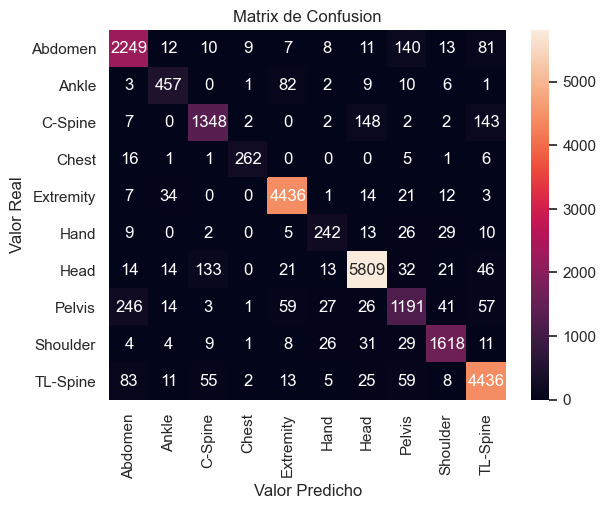

,Logistic_Regression
Sensibilidad,0.863888
Accuracy,0.913831
Precision,0.878422


In [279]:
evaluacion(y_test, ypred_lr, model="Logistic_Regression")

### Naive Bayes

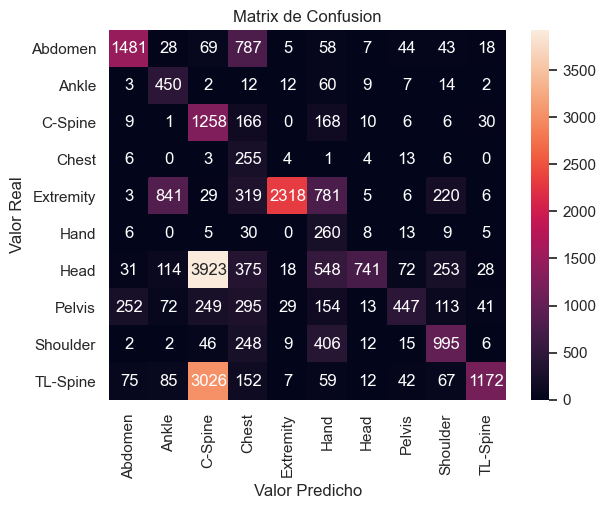

,Naive_Bayes
Sensibilidad,0.550168
Accuracy,0.388652
Precision,0.543453


In [283]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train.toarray(), y_train)

ypred_gnb = gnb.predict(X_test.toarray())

evaluacion(y_test, ypred_gnb, model="Naive_Bayes")

### KNN - n arbitrario manual

In [284]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Hyperparametros
#parameters_knn = {"n_neighbors" : list(range(1, 3))}

'''clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1) '''
                   

# Fit el modelo ya seleccionado
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [285]:
ypred_knn = knn.predict(X_test)

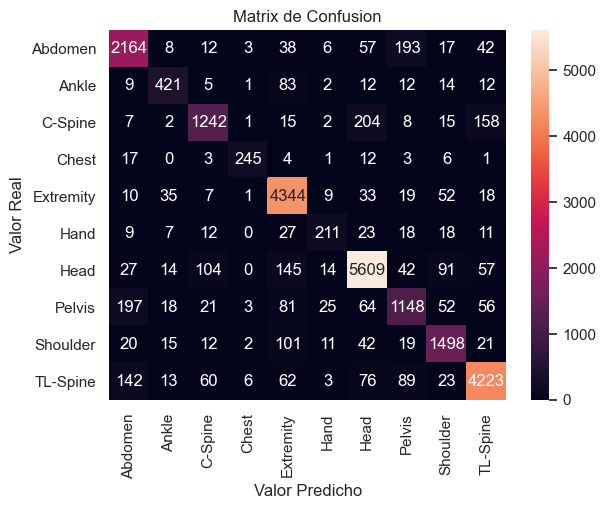

,KNN
Sensibilidad,0.813461
Accuracy,0.874746
Precision,0.843833


In [286]:
evaluacion(y_test, ypred_knn, model="KNN")

### KNN RandomSearch

In [287]:
from sklearn.model_selection import RandomizedSearchCV

knn2 = KNeighborsClassifier()

# Hyperparametros
parameters_knn2 = {"n_neighbors" : list(range(1, 15))}

random = RandomizedSearchCV(knn2, parameters_knn2, n_iter=2, cv=3, scoring='accuracy',random_state=10)


'''clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1) '''
                   

# Fit el modelo ya seleccionado
random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=2,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13,
                                                        14]},
                   random_state=10, scoring='accuracy')

In [289]:
ypred_random = random.predict(X_test)

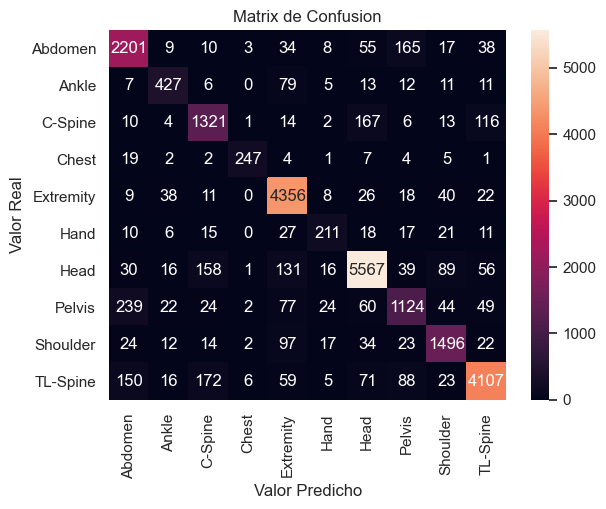

,KNN-random
Sensibilidad,0.816981
Accuracy,0.872757
Precision,0.835081


In [290]:
evaluacion(y_test, ypred_random, model="KNN-random")